In [2]:
# Add librarie to PYTHONPATH
import sys
import os
sys.path.append( os.path.join(os.getcwd(), 'genre-classifier') )

fatal: destination path 'genre-classifier' already exists and is not an empty directory.


In [3]:
!pip install gensim # word2vec libs

import pandas as pd
import numpy as np
from collections import Counter
from scipy.sparse import csr_matrix
from keras.preprocessing.text import Tokenizer
from sampling import stratified_kfolds
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns # Importar biblioteca para graficos
import json # necessário utilizar para ler lista dentro de dataframe ['[a,b,c]']

##incluir bibliotecas necessarias para pré-processamento
import nltk
import string
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
lemmatizer = WordNetLemmatizer()
stopwords_list = stopwords.words('english')
from gensim.models import Word2Vec
import pickle #utilizado para serializar o modelo 
import inspect #função para automatizar nomenclatura de arquivos em retrieve_name necessita "import inspect"

#Importar métodos criados 
from lib_reglog import * #importar metodo de regressão logística
from lib_naive import * #importar metodo Naive Bayes
from lib_knn import * #importar metodo KNN
from lib_mlp import * #importar metodo MLP
from lib_dectree import * #importar metodo Arvore de Decisão
from svmutil import svm_train #importar metodo de Maquinas de Vetores de Suporte
from svmutil import svm_predict
from metrics import * #importar metodo que calcula as medidas
import time

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
distributed 1.22.0 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Using TensorFlow backend.


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/emanuelhuber/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/emanuelhuber/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/emanuelhuber/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/emanuelhuber/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
#IMPORTAR OS DADOS BRUTOS
df_train = pd.read_csv('training.csv', names=['category', 'sentence'])

#VIZUALIZAR DADO IMPORTADO
# df_train.head() 

## Análise exploratória dos dados
Mostrando a distribuição dos dados por classe

In [4]:
dist_values = df_train['category'].value_counts()/df_train['category'].shape[0]
display(dist_values)

Arts_&_Culture_&_Entertainment    0.371209
Sport                             0.346324
Science_&_Technology              0.132524
Economy_&_Business_&_Financial    0.075386
Politics                          0.074558
Name: category, dtype: float64

Mostrando estatísticas básicas 

In [5]:
def show_statistics(df):
    r = dict()

    r['category'] = df.assign(word_count=df['sentence'].str.split().str.len()) \
            .groupby('category') \
            .agg({'category': 'count', 'word_count': 'sum'}) \
            .rename(columns={'category':'category_count'}) \
            .reset_index()['category'].values
    r['word_count'] = df.assign(word_count=df['sentence'].str.split().str.len()) \
            .groupby('category') \
            .agg({'category': 'count', 'word_count': 'sum'}) \
            .rename(columns={'category':'category_count'}) \
            .reset_index()['word_count'].values

    r['max_word_count'] = df.assign(max_word_count=df['sentence'].str.split().str.len()) \
            .groupby('category') \
            .agg({'category': 'count', 'max_word_count': 'max'}) \
            .rename(columns={'category':'category_count'}) \
            .reset_index()['max_word_count']

    r['min_word_count'] = df.assign(min_word_count=df['sentence'].str.split().str.len()) \
            .groupby('category') \
            .agg({'category': 'count', 'min_word_count': 'min'}) \
            .rename(columns={'category':'category_count'}) \
            .reset_index()['min_word_count']

    r['mean_word_count'] = df.assign(mean_word_count=df['sentence'].str.split().str.len()) \
            .groupby('category') \
            .agg({'category': 'count', 'mean_word_count': 'mean'}) \
            .rename(columns={'category':'category_count'}) \
            .reset_index()['mean_word_count']

    display(pd.DataFrame(r))


show_statistics(df_train)

,category,word_count,max_word_count,min_word_count,mean_word_count
0,Arts_&_Culture_&_Entertainment,14514517,63,2,11.114910
1,Economy_&_Business_&_Financial,3231799,65,2,12.186455
2,Politics,3029950,62,2,11.552172
3,Science_&_Technology,5391751,64,2,11.565342
4,Sport,14793253,98,2,12.142348


In [6]:
df_droped = df_train.drop(  df_train.index[df_train['sentence'].str.split().str.len() < 1 ], axis=0)

Analisando os dados com 2 palavras podemos perceber um ruído nos dados, que podem vir a prejudicar os classificadores, por isso serão removidos.

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


[Text(0.5,0,'')]

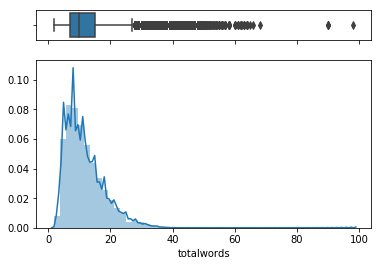

In [7]:
df_droped['totalwords'] = [len(x.split()) for x in df_droped['sentence'].tolist()]

# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(df_droped['totalwords'], ax=ax_box)
sns.distplot(df_droped['totalwords'], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')


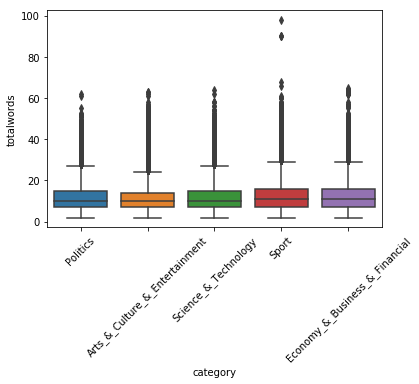

In [8]:
# cria o boxplot
ax = sns.boxplot(x="category", y=df_droped['totalwords'], data=df_droped, whis=1.5)
plt.setp(ax.get_xticklabels(), rotation=45)
# mostra o gráfico usando a função show() da matplotlib
plt.show()

In [9]:
# Removendo pontuação e mostrando as palavras mais frequentes com e sem stop_words


def clean_data(df, debug=True):
    df_clean = df.copy()

    # Removing punctuation
    table = str.maketrans('', '', string.punctuation)
    df_clean['sentence'] = df_clean['sentence'].str.split().apply(lambda x: [w.lower().translate(table) for w in x])

    if debug:
        df_clean.head()
    
    return df_clean

df_clean = clean_data(df_droped, False)

def show_most_frequent_words(df, n_words=500, stop_words=False):
    
    if stop_words:
        #with open('stopwords.json', 'r') as f:
        #    words = json.loads(f.read())
        words = stopwords.words('english')
        tokens = [token for s in df['sentence'] for token in s if token != "" and not token in words]
    else:
        tokens = [token for s in df['sentence'] for token in s if token != ""]
    
    labels, values = zip(*Counter( tokens ).most_common(n_words))
    indexes = np.arange(len(labels[:20]))
    width = 1

    fig=plt.figure(figsize=(15, 5))
    plt.bar(indexes[:20], values[:20], width, edgecolor='black')
    plt.xticks(indexes + width * .2, labels[:20])
    if stop_words:
        plt.title('20 palavras mais comuns sem stop words')
    else:
        plt.title('20 palavras mais comuns com stop words')
    plt.show()

max_words = 500
show_most_frequent_words(df_clean, stop_words=True)
show_most_frequent_words(df_clean, stop_words=False)

In [5]:
def pre_process(doc, c_sinonimo, metodo):
################################################
# FUNÇÃO PARA PRE-PROCESSAMENTO
# - word_tokenize = segmenta as sentenças em palavras
# - POS-TAG = anotar palavras de acordo com sua classificação gramatical ou de acordo com sua função no discurso
# - non_stopwords = remove as palavras mais comuns
# - lower = minimiza todas as palavras
# - non_punctuation = remove a pontuação
# - são padronizadas as classificações gramaticais devido a possuir grande variabilidade e por necessidar utiliza-las na "lemmatização"
# - "lemmatização" = deixa na palavra a parte que não varia conforme senteças, o radical. (e.g: bigger -> big)
# - synset.hypernyms (hyponyms, member_holonyms, lemma_names) = encontra as palavras sinonimas com base no wordnet
# - por ultimo é estruturado o dado conforme o método escolhido:
# metodo 0 -> Retorna dois vetores, um de palavras e outro de postag
# [NAME1 NAME2 NAME3][POS1 POS2 POS3] - PARA UTILIZAR APENAS COM C-BOW N-GRAM >= 1
# metodo 1 -> retorna 1 vetor com nomes e pos tag juntos
# [NAME1_POS1 NAME2_POS2 NAME3_POS3] - PARA UTILIZAR APENAS COM C-BOW N-GRAM >= 1
# c_sinonimo - com sinonimo é igual a 1 e sem é igual a 0
################################################

    dado_preprocessado = []
    sinonimos2_temp = []
    for d in doc:
        words = word_tokenize(d) # separa sentenças em lista de tuplas onde cada tupla é uma palavra
        pos_tags = pos_tag(words) #add pos tag
        non_stopwords = [w for w in pos_tags if not w[0].lower() in stopwords_list] #remove stopwords
        non_stopwords = [w for w in non_stopwords if len(w[0])>1]
        non_punctuation = [] 
        # remover pontuação e espaços
        for w in non_stopwords:
            replace_punctuation = str.maketrans(string.punctuation,' '*len(string.punctuation))
            wtemp = w[0].lower().translate(replace_punctuation)
            w2 = (wtemp.replace(" ",""), w[1])
            if not w[0][0] in string.punctuation:
                non_punctuation.append(w2) 
        non_punctuation = [w for w in non_punctuation if len(w[0])>1]
        lemmas = []
        pos2=[]
        lemmas2 = []
        doc_trans = []
        # Arruma pos tags para utilizar lemmatização e encontrar palavras similares dado postag
        for w in non_punctuation: 
            if w[1].startswith('J'):
                pos = wordnet.ADJ
            elif w[1].startswith('V'):
                pos = wordnet.VERB
            elif w[1].startswith('N'):
                pos = wordnet.NOUN
            elif w[1].startswith('R'):
                pos = wordnet.ADV
            else:
                pos = wordnet.NOUN
            lemma_temp = lemmatizer.lemmatize(w[0], pos) #aplica a lemmatização antes de procurar sinonimos
            pos2.append(pos) # usado no metodo 0
            lemmas2.append(lemma_temp) # usado no metodo 0
            lemmas.append((lemma_temp,pos)) # usado no metodo 1
        sinonimos2_temp = list(dict.fromkeys(lemmas))
        sinonimos2 = []
        if c_sinonimo == 1: #inclui os sinonimos 
            for p in range(len(sinonimos2_temp)):
                sinonimos = wordnet.synsets(sinonimos2_temp[p][0], pos=sinonimos2_temp[p][1])
                temp_list = []
                temp_list2 = []
                for synset in sinonimos:
                    temp_list.append(synset.hypernyms())
                    temp_list.append(synset.hyponyms())
                    temp_list.append(synset.member_holonyms())
                    temp_list = list(np.hstack(temp_list))
                    temp_list = list(dict.fromkeys(temp_list))
                if len(temp_list)>1:
                    for synset2 in temp_list:
                        temp_list2.append(synset2.lemma_names())
                        temp_list2 = list(np.hstack(temp_list2))
                        temp_list2 = list(dict.fromkeys(temp_list2))
                if (len(temp_list2)>0):
                    for w2 in (temp_list2):
                        if metodo == 0:
                            w3 = (w2.replace("_"," "))
                        else:
                            w3 = (w2, sinonimos2_temp[p][1])
                        sinonimos2.append(w3)
            sinonimos2 = list(dict.fromkeys(sinonimos2))
            sinonimos2.extend(lemmas)
        else:
            if metodo == 0:
                sinonimos2.extend(lemmas2)
            else:
                sinonimos2.extend(lemmas)
        #metodos possuem diferentes tipos de retorno de função
        if metodo == 0:
            doc_trans = [[" ".join(["".join(w) for w in sinonimos2])]]
            doc_trans.append(pos2)
        else:
            doc_trans = [" ".join(["_".join(w) for w in sinonimos2])]
        dado_preprocessado.append(doc_trans)
    return dado_preprocessado

In [6]:
# REMOVER AMOSTRAS DUPLICADAS MANTENDO A PRIMEIRA
def delDuplicatas(df_dataset):
    df_duplicates = df_dataset[df_dataset.duplicated(subset=['sentence'],keep=False)] 
    df_dataset = df_dataset.drop_duplicates(keep='first')
    df_duplicates = df_dataset[ df_dataset.duplicated(subset=['sentence'],keep=False)]
        # verifica se ainda existem valores redundantes
    while(len(df_duplicates)>0):     
        # se tiver valores redundantes ou inconsistentes, imprime 
        df_dataset = delInconsistencias(df_dataset)
        df_duplicates = df_dataset[ df_dataset.duplicated(subset=['sentence'],keep=False)]
    return df_dataset

# remove todas as amostras inconsistentes da base de dados (e.g. com mais de uma classe)
def delInconsistencias(df_dataset):
    df_dataset = df_dataset.drop_duplicates(subset=['sentence'],keep=False)
    return df_dataset

In [7]:
#REMOVENDO OUTLIERS DE SENTENÇAS COM MUITAS PALAVRAS CONSIDERANDO A DISTRIBUIÇÃO NORMAL RELATIVA ÀS CLASSES
# Uma das maneiras mais simples de tratar um outlier é remover aqueles valores que são menores que
# Q1 - 1.5 * IQR ou maiores que Q3 + 1.5 * IQR, onde Q1 é o primeiro quartil, Q3 é o terceiro quartil
# e IQR é o intervalo interquartil. O IQR pode ser calculado pela seguinte equação: IQR = Q3-Q1. 

def remove_outliers(df):
    # CONSIDERAÇÕES
    # -> Para utilizar o método considerado é necessário colocar interpolation='midpoint' na funcao de quartile em Pandas
    # -> Q1 | k = m*0,2 5   sendo m o numero de amostras
    # -> Q3 | k = m*0,75
    # -> IQR = Q3 - Q1 | k = m*(0,75-0,25) = m*(0,5)
    # -> Limite Inferior = Q1-1,5*IQR | k = m*0,25-1,5*0,5*m = m*(0,25-0,75) = -0,5*m
    # -> Limite Superior = Q3+1,5*IQR | k = m*0,75+1,5*0,5*m = m*(0,75+0,75) = 1,5*m
    df['totalwords'] = [len(x.split()) for x in df['sentence'].tolist()]
    # cria o boxplot
    ax = sns.boxplot(x="category", y=df['totalwords'], data=df, whis=1.5)
    plt.setp(ax.get_xticklabels(), rotation=45)
    # mostra o gráfico usando a função show() da matplotlib
    plt.show()
    df_distribuicao = df.groupby(['category']).quantile([0.25],interpolation='midpoint')
    df_distribuicao.reset_index(inplace=True)
    df_distribuicao_category = df_distribuicao.category.values
    df_distribuicao_q1 = df_distribuicao.totalwords.values
    df_distribuicao_q3 = df.groupby(['category']).quantile([0.75],interpolation='midpoint').values
    IQR = df_distribuicao_q3 - df_distribuicao_q1
    Lim_Inferior = df_distribuicao_q1-(1.5*IQR)
    Lim_Superior = df_distribuicao_q3+(1.5*IQR)
    nao_outliers = []
    for c,li,ls in zip(df_distribuicao_category,Lim_Inferior[0],Lim_Superior[0]):
        temp_bool = df[df.totalwords.between(li, ls)]
        temp_bool = temp_bool[temp_bool.category == c]
        nao_outliers.append(temp_bool.index.values.tolist())
    nao_outliers = list(np.hstack(nao_outliers))
    outliers = df.index.difference(nao_outliers)
    df_dataset = df.drop(outliers,axis=0)
    return df_dataset

In [8]:
def remove_duplicate_and_outliers(df):
    print("Tamanho do dataset preprocessado")
    print(df.shape)
    df_temp = delDuplicatas( df )
    df_temp = remove_outliers(df_temp)
    print("Tamanho do dataset preprocessado sem duplicatas e sem outliers")
    print(df_temp.shape)
    return df_temp

###########################################
Criando arquivo 2 de 4 de preprocessamento
Tamanho do dataset preprocessado
(3517858, 2)


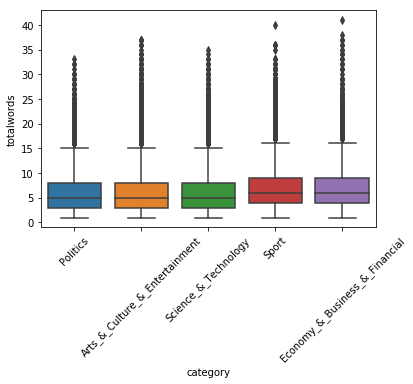

Tamanho do dataset preprocessado sem duplicatas e sem outliers
(3069942, 3)
postag_junto_s_sinonimo.csv criado
###########################################


In [14]:
###############################################################
###############################################################
##################### PRE-PROCESSAMENTO #######################
###############################################################
###############################################################

### Para realizar teste de implementação é recomendado LIMITAR O DOC À 200 SENTENCAS INICIAIS[0:200]###
### O PRÉ-PROCESSAMENTO É LENTO, PORTANTO É NECESSÁRIO COMENTAR O QUE NÃO FOR USAR, 
# Neste caso não será realizado:
# - PRÉ-PROCESSAMENTO COM POSTAG JUNTO + SINONIMOS
# - PRÉ-PROCESSAMENTO SEM POSTAG JUNTO + SINONIMOS
# - REALIZAR PRÉ-PROCESSAMENTO SEM POSTAG JUNTO SEM SINONIMOS

# Referenciar dataset de sentenças
doc = df_droped['sentence'].values  # limitando aqui as 200 amostras = df_droped['sentence'].values[0:200]

# # REALIZAR PRÉ-PROCESSAMENTO COM POSTAG JUNTO + SINONIMOS
# print("###########################################")
# print("Criando arquivo 1 de 4 de preprocessamento")
# #declara variáveis
# c_sinonimo = 1 # com sinonimo
# metodo = 1 #com metodo postag junto
# dado_preprocessado = pre_process(doc, c_sinonimo, metodo) #chama função
# df_temp = pd.DataFrame(dado_preprocessado, columns=['sentence'])
# df_ptjcs = pd.concat([df_temp,df_droped['category']], axis=1, ignore_index=True, join='inner')
# df_ptjcs.rename(columns={1:'category', 0:'sentence'}, inplace=True)
# df_ptjcs = df_ptjcs.dropna()
# df_ptjcs_filename = r'postag_junto_c_sinonimo.csv'
# df_ptjcs.to_csv(df_ptjcs_filename, index=False)
# print(df_ptjcs_filename + " criado")
# print("###########################################")


# REALIZAR PRÉ-PROCESSAMENTO COM POSTAG JUNTO SEM SINONIMOS
print("###########################################")
print("Criando arquivo 2 de 4 de preprocessamento")
#declara variáveis
c_sinonimo = 0 # sem sinonimo
metodo = 1 #com metodo postag junto
dado_preprocessado = pre_process(doc, c_sinonimo, metodo) #chama função
df_temp = pd.DataFrame(dado_preprocessado, columns=['sentence'])
df_ptjss = pd.concat([df_temp,df_droped['category']], axis=1, ignore_index=True, join='inner')
df_ptjss.rename(columns={1:'category', 0:'sentence'}, inplace=True)
df_ptjss = df_ptjss.dropna()
df_ptjss = remove_duplicate_and_outliers(df_ptjss)
df_ptjss_filename = r'postag_junto_s_sinonimo.csv'
df_ptjss.to_csv(df_ptjss_filename, index=False)
print(df_ptjss_filename + " criado")
print("###########################################")


# # REALIZAR PRÉ-PROCESSAMENTO SEM POSTAG JUNTO + SINONIMOS
# print("###########################################")
# print("Criando arquivo 3 de 4 de preprocessamento")
# #declara variáveis
# c_sinonimo = 1 # com sinonimo
# metodo = 0 #com metodo postag separado
# dado_preprocessado = pre_process(doc, c_sinonimo, metodo) #chama função
# df_temp = pd.DataFrame(dado_preprocessado, columns=['sentence', 'postag'])
# df_ptscs = pd.concat([df_temp,df_droped['category']], axis=1, ignore_index=True, join='inner')
# df_ptscs.rename(columns={2:'category',1:'postag', 0:'sentence'}, inplace=True)
# df_ptscs = df_ptscs.dropna()
# df_ptscs_filename = r'postag_separado_c_sinonimo.csv'
# df_ptscs.to_csv(df_ptscs_filename, index=False)
# print(df_ptscs_filename + " criado")
# print("###########################################")


# # REALIZAR PRÉ-PROCESSAMENTO SEM POSTAG JUNTO SEM SINONIMOS
# print("###########################################")
# print("Criando arquivo 4 de 4 de preprocessamento")
# #declara variáveis
# c_sinonimo = 0 # sem sinonimo
# metodo = 0 #com metodo postag separado
# dado_preprocessado = pre_process(doc, c_sinonimo, metodo) #chama função
# df_temp = pd.DataFrame(dado_preprocessado, columns=['sentence', 'postag'])
# df_ptsss = pd.concat([df_temp,df_droped['category']], axis=1, ignore_index=True, join='inner')
# df_ptsss.rename(columns={2:'category',1:'postag', 0:'sentence'}, inplace=True)
# df_ptsss = df_ptsss.dropna()
# df_ptsss_filename = r'postag_separado_s_sinonimo.csv'
# df_ptsss.to_csv(df_ptsss_filename, index=False)
# print(df_ptsss_filename + " criado")
# print("###########################################")

Pré-processamento dos dados (bag of words), cbow e skip-gram

In [9]:
def bow_transform(sentences, max_words, mode, test=False):
    if test==True:
        tokenizer = pickle.load(open('df_ptjss_TFIDF_tokenizer_transform.sav', 'rb'))
    else:
        tokenizer = Tokenizer(num_words = max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
        #filters=None #não pode filtrar "_"
        tokenizer.fit_on_texts(sentences)
    dataset = tokenizer.texts_to_matrix(sentences, mode=mode) #mode default é binario
    return tokenizer, dataset

In [10]:
# Proximidade semântica com janela (window=3) igual a 3 e tamanho de neurônios(size) igual a 100 (size=100)
# utilizando a técnica de cbow (sg=2)
# (min_count=2, sg=2, window=3, size=100) 
# window e size podem ser passados como hiperparametros

#sg - algoritmo de treino: 1 para skip-gram; 2 ou qualquer outro valor é CBOW.
class Word2VecTransformer(object):
    ALGO_SKIP_GRAM=1
    ALGO_CBOW=2    
    
    def __init__(self, algo=1):
        self.algo = algo
    
    def fit(self, X, y=None):     
        X = [nltk.word_tokenize(x) for x in X]
        self.word2vec = Word2Vec(X, min_count=2, sg=self.algo, window=5, size=200)
        # Pegamos a dimensão da primeira palavra, para saber quantas dimensões estamos trabalhando,
        # assim podemos ajustar nos casos em que aparecerem palavras que não existirem no vocabulário.
        first_word = next(iter(self.word2vec.wv.vocab.keys()))
        self.num_dim = len(self.word2vec[first_word])       
        return self
    
    def transform(self, X, Y=None):        
        X = [nltk.word_tokenize(x) for x in X]
        
        return np.array([np.mean([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.num_dim)], axis=0) 
                         for words in X])
    def get_params(self, deep=True):
        return {}

In [29]:
#função para automatizar nomenclatura de arquivos em retrieve_name necessita "import inspect"
def retrieve_name(var): 
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

def XY_transform(df, method,df_filename, test=False):
    # DF com colunas de sentenças e categoria nomeadas "sentence" e "category"
    # method = "BOW" # (bag of words)
    # method = "CBOW" # CBOW (Continuos bag of words)
    # method = "SG" # skip-gram
    # Sentencas utilizadas para treino
    sentences = list(df['sentence'].values)  # [:200] quando o dataset inteiro ja estiver pre-processao
    y_train = df['category'].values
       
    if method == "BOW":
        #BOW
        max_words = 500 # Incluir parâmetro máximo para dicionario
        mode = "count"
        tokenizer, X_train = bow_transform(sentences, max_words, mode, test)
        if test == False:
            # SERIALIZAR O MODELO DE TOKENIZAÇÃO PARA TRANSFORMAR DADO DE TESTE
            model_filename = df_filename + "_tokenizer_transform.sav"
            pickle.dump(tokenizer, open(model_filename, 'wb'))
            print('Modelo de tokenizer salvo como ' + model_filename)
    
    if method == "TFIDF":
        #BOW
        max_words = 500 # Incluir parâmetro máximo para dicionario
        mode = "tfidf"
        tokenizer, X_train = bow_transform(sentences, max_words, mode, test)
        if test == False:
            # SERIALIZAR O MODELO DE TOKENIZAÇÃO PARA TRANSFORMAR DADO DE TESTE
            model_filename = df_filename + "_tokenizer_transform.sav"
            pickle.dump(tokenizer, open(model_filename, 'wb'))
            print('Modelo de tokenizer salvo como ' + model_filename)
        
    elif method == "CBOW":
        #CBOW
        X_train_model = Word2VecTransformer(algo=2).fit(sentences)
        X_train = X_train_model.transform(sentences)
        if test == False:
            # SERIALIZAR O MODELO PARA TRANSFORMAR DADO DE TESTE
            model_filename = df_filename + "_transform.sav"
            pickle.dump(X_train_model, open(model_filename, 'wb'))
            print('Modelo salvo como ' + model_filename)
        
    elif method == "SG":
        #skipgram
        X_train_model = Word2VecTransformer(algo=1).fit(sentences)
        X_train = X_train_model.transform(sentences)
        if test == True:
            # SERIALIZAR O MODELO PARA TRANSFORMAR DADO DE TESTE
            model_filename = df_filename + "_transform.sav"
            pickle.dump(X_train_model, open(model_filename, 'wb'))
            print('Modelo salvo como ' + model_filename)
    
    return X_train, y_train

In [22]:
################################################
# FUNÇÃO PARA SALVAR DADOS PRE-PROCESSADOS E 
# TRANSFORMADOS VETORIALMENTE PARA REALIZAR
# TREINO E TESTE
################################################

def save_transform(df, method,df_filename, test=False):
    # realizar transformação
    X, y = XY_transform(df, method,df_filename, test)
    #Salvar arquivo
    d = {'sentence': X.tolist(), 'category': y.tolist()}
    df2 = pd.DataFrame(data=d)
    df_filename = df_filename+'.csv'
    df2.to_csv(df_filename, index=False)
    print(df_filename + " criado")
    return df2

In [13]:
################################################
# CARREGAR DADOS JA PREPROCESSADOS
################################################
# df_ptjcs = pd.read_csv('postag_junto_c_sinonimo.csv', header=0).dropna()
df_ptjss = pd.read_csv('postag_junto_s_sinonimo.csv', header=0).dropna()
# df_ptscs = pd.read_csv('postag_separado_c_sinonimo.csv', header=0).dropna()
# df_ptsss = pd.read_csv('postag_separado_s_sinonimo.csv', header=0).dropna()


In [20]:
show_statistics(df_ptjss)

,category,word_count,max_word_count,min_word_count,mean_word_count
0,Arts_&_Culture_&_Entertainment,6630190,15,1,5.791277
1,Economy_&_Business_&_Financial,1413708,14,1,6.143111
2,Politics,1377916,15,1,5.909009
3,Science_&_Technology,2476731,15,1,5.999600
4,Sport,6656917,14,1,6.346267


In [14]:
################################################
# TRANSFORMAR DADOS PREPROCESSADOS
################################################
# É necessário realizar a transformação dos dados para realizar treinamento
# desta maneira é necessário também salvar o modelo de transformação como objeto
# para posteriormente realizar a transformada padronizada nas fases de treino

#Inserir parâmetros conforme:
# method_list = ["BOW","CBOW","SG"]
# df_list = [df_ptjcs,df_ptjss,df_ptscs,df_ptsss]

# method_list = ["BOW"] #Neste documento será realizado apenas o método BOW
method_list = ["TFIDF"]
df_list = [df_ptjss] #Neste caso será utilizado apenas o dado preprocessado sem sinonimo e com postag junto
for d in df_list:
    for m in method_list:
        df_filename = retrieve_name(d)[0]+'_'+m
        df_train = save_transform(d,m,df_filename) 

Modelo de tokenizer salvo como df_ptjss_TFIDF_tokenizer_transform.sav
df_ptjss_TFIDF.csv criado


In [71]:
################################################
# CARREGAR DADOS PREPROCESSADOS E TRANSFORMADOS
################################################
# FILENAME => df_list[0] para df_ptjcs, method_list[0] para "BOW"

print("Reading csv")
df_temp = retrieve_name(df_list[0])[0]
method_temp = method_list[0]
df_filename = df_temp+'_'+method_temp+'.csv' #Mudar nomes 
df_train = pd.read_csv(df_filename, header=0) # é preciso incluir nrows=10000 para executar apenas as 10000 primeiras amostras
X_train = np.asarray([np.array(json.loads(x)) for x in df_train['sentence']])

print("Parsing csv")
df_test = pd.read_csv('test.csv',names=['category', 'sentence'])
df_filename = "df_test_TFIDF_test"

#declara variáveis e limpa dados
doc = df_test['sentence'].values
c_sinonimo = 0 # sem sinonimo
metodo = 1 #com metodo postag junto
dado_preprocessado = pre_process(doc, c_sinonimo, metodo) #chama função
df_temp = pd.DataFrame(dado_preprocessado, columns=['sentence'])
df_test = pd.concat([df_temp,df_test['category']], axis=1, ignore_index=True, join='inner')
df_test.rename(columns={1:'category', 0:'sentence'}, inplace=True)
df_test = save_transform(df_test,method_list[0],df_filename,test=True) 
df_test = pd.read_csv('df_test_TFIDF_test.csv', header=0)

X_test = np.asarray([np.array(json.loads(x)) for x in df_test['sentence']])
# X_test = df_test['sentence'].values
labels = {v:k for k, v in enumerate(df_test['category'].unique())}
y_test = df_test['category'].apply(lambda x: labels[x]).values


Reading csv
Parsing csv
df_test_TFIDF_test.csv criado


In [65]:
# tokenizer = pickle.load(open('df_ptjss_TFIDF_tokenizer_transform.sav', 'rb'))
# len(list(tokenizer.word_counts)) #TAMANHO DO DICIONARIO 

# VERIFICAR QUANTAS AMOSTRAS ZERADAS EXISTEM COM O TAMANHO DE max_words UTILIZADO
count = 0
for i in range(len(X_train)):
    if np.count_nonzero(X_train[i]) == 0:
        count = count + 1 
print(count*100/len(X_train))

count = 0
for i in range(len(X_test)):
    if np.count_nonzero(X_test[i]) == 0:
        count = count + 1 
print(count*100/len(X_test))

18.73
16.2


In [66]:
#Função utilizada para realizar estratificação 
def stratified_holdOut_nsamples(target, n):

    train_index = []

    classes = np.unique(target)
    m = [len(np.where(target == c)[0]) for c in classes]
    ps = [len(np.where(target == c)[0])/target.shape[0] for c in classes]
    for i, c in enumerate(classes):
        train_index = np.union1d(train_index, np.where(target == c)[0][: int(n * ps[i] ) ]).astype('int')

    return train_index

In [69]:
################################################
# TESTAR DIFERENTES MÉTODOS DE TREINAMENTO COM 
# VALIDAÇÃO CRUZADA (SVM)
################################################

# print("Parsing csv")
# df_test = pd.read_csv('df_ptjss_BOW_test.csv', header=0)
# X_test = np.asarray([np.array(json.loads(x)) for x in df_test['sentence']])
# labels = {v:k for k, v in enumerate(df_test['category'].unique())}
# y_test = df_test['category'].apply(lambda x: labels[x]).values

model_list = [None]
model_list_name = ["SVM"]
results = dict()

for model,name in zip(model_list,model_list_name):
    print("###########################################")
    print("Realizando treinamento do modelo "+name)
    for i in (df_train.shape[0], df_train.shape[0]+1):
        df_indexes = stratified_holdOut_nsamples(df_train['category'].values, i)
        df_train_tests = df_train.iloc[df_indexes, :]

        labels = {v:k for k, v in enumerate(df_train_tests['category'].unique())}
        y_train = df_train_tests['category'].apply(lambda x: labels[x]).values
        folds = stratified_kfolds( df_train_tests['category'].values, 5, df_train_tests['category'].unique() )
        best_model = None
        best_acc = 0
        best_acc_train = 0
        perf_train = []
        perf_test = []
        t_kf = time.time()
        for j, (train_index, test_index) in enumerate(folds):
            Xtrain, Xtest = X_train[train_index], X_train[test_index]
            ytrain, ytest = y_train[train_index], y_train[test_index]
            if name == 'SVM':
                model = svm_train(ytrain, Xtrain)
                pred_train = svm_predict([], Xtrain, model)[0]
                pred_test = svm_predict([], Xtest, model)[0]
            else:
                model.fit(Xtrain, ytrain)
                pred_train = model.predict(Xtrain)
                pred_test = model.predict(Xtest)
            print('Acuracia treino: %.2lf' % (np.mean( pred_train == ytrain ) * 100))
            print('Acuracia val: %.2lf' % (np.mean( pred_test == ytest ) * 100))
            if (np.mean( pred_test == ytest ) * 100 > best_acc):
                best_acc = np.mean( pred_test == ytest ) * 100
                best_acc_train = np.mean( pred_train == ytrain ) * 100
                best_model = model
            #print("Time for 1 kfold it: ", time.time()-t_kf)
        print('Iteracao: ', i / 1000)
        perf_train.append(best_acc_train)
        perf_test.append(best_acc)

        if name == 'SVM':
            pred_r_test = svm_predict([], Xtest, best_model)[0]
        else: pred_r_test = model.predict(X_test)
        conf = get_confusionMatrix(y_test, pred_r_test, df_test['category'].unique())
        res = relatorioDesempenho(conf, df_test['category'].unique(), False) #True) #True para mostrar relatorio metricas
        print('Acuracia test: %.2lf' % (np.mean( pred_r_test == y_test ) * 100))
        if not name in results.keys(): results[name] = dict()
        results[name][str(i)] = ( best_acc_train, best_acc, res )
        with open('results_svm.pickle', 'wb') as handle:
            pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
        # SERIALIZAR O MODELOS TEMPORÁRIOS
        #model_filename = str(df_temp) + "_" + str(method_temp) + "_" + str(name) + ".sav"
        #pickle.dump(best_model, open(model_filename, 'wb'))
        # curva_aprendizado(perf_train, perf_test)

###########################################
Realizando treinamento do modelo SVM
Accuracy = 0.624844% (50/8002) (classification)
Accuracy = 0.0500751% (1/1997) (classification)
Acuracia treino: 64.07
Acuracia val: 57.19
Accuracy = 0.500125% (40/7998) (classification)
Accuracy = 0.29985% (6/2001) (classification)
Acuracia treino: 63.57
Acuracia val: 59.57
Accuracy = 0.4375% (35/8000) (classification)
Accuracy = 0.30015% (6/1999) (classification)
Acuracia treino: 64.62
Acuracia val: 58.38
Accuracy = 0.700175% (56/7998) (classification)
Accuracy = 0.049975% (1/2001) (classification)
Acuracia treino: 64.97
Acuracia val: 58.27
Accuracy = 0.4001% (32/7998) (classification)
Accuracy = 0.149925% (3/2001) (classification)
Acuracia treino: 64.44
Acuracia val: 57.27
Iteracao:  10.0
Accuracy = 0.7996% (16/2001) (classification)
Acuracia test: 0.00


/home/emanuelhuber/mestrado/genre-classifier/metrics.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  cm[i][j] = len(np.intersect1d(np.where(Y_test==classes[i])[0], np.where(Y_pred==classes[j])[0]))
/home/emanuelhuber/mestrado/genre-classifier/metrics.py:38: RuntimeWarning: invalid value encountered in long_scalars
  acuracia = np.diag(matriz_confusao).sum() / np.sum(matriz_confusao)
/home/emanuelhuber/mestrado/genre-classifier/metrics.py:39: RuntimeWarning: invalid value encountered in true_divide
  revocacao = np.diag(matriz_confusao) / np.sum(matriz_confusao, axis=1)
/home/emanuelhuber/mestrado/genre-classifier/metrics.py:40: RuntimeWarning: invalid value encountered in true_divide
  precisao = np.diag(matriz_confusao) / np.sum(matriz_confusao, axis=0)
/home/emanuelhuber/mestrado/genre-classifier/metrics.py:45: RuntimeWarning: invalid value encountered in long_scalars
  revocacao_microAverage = np.d

Accuracy = 0.624844% (50/8002) (classification)
Accuracy = 0.0500501% (1/1998) (classification)
Acuracia treino: 64.06
Acuracia val: 57.16
Accuracy = 0.500063% (40/7999) (classification)
Accuracy = 0.249875% (5/2001) (classification)
Acuracia treino: 63.56
Acuracia val: 59.62
Accuracy = 0.437445% (35/8001) (classification)
Accuracy = 0.30015% (6/1999) (classification)
Acuracia treino: 64.70
Acuracia val: 58.33
Accuracy = 0.662583% (53/7999) (classification)
Accuracy = 0% (0/2001) (classification)
Acuracia treino: 64.98
Acuracia val: 58.12
Accuracy = 0.40005% (32/7999) (classification)
Accuracy = 0.09995% (2/2001) (classification)
Acuracia treino: 64.43
Acuracia val: 57.32
Iteracao:  10.001
Accuracy = 0.7996% (16/2001) (classification)
Acuracia test: 0.00


In [ ]:
################################################
# TESTAR DIFERENTES MÉTODOS DE TREINAMENTO COM 
# VALIDAÇÃO CRUZADA (Árvore de Decisão)
################################################

print("Parsing csv")
df_test = pd.read_csv('df_ptjss_BOW_test.csv', header=0, nrows=500)
X_test = np.asarray([np.array(json.loads(x)) for x in df_test['sentence']])
labels = {v:k for k, v in enumerate(df_test['category'].unique())}
y_test = df_test['category'].apply(lambda x: labels[x]).values

model_list = [ArvoreDecisao()]
model_list_name = ["Tree"]
results = dict()

for model,name in zip(model_list,model_list_name):
    print("###########################################")
    print("Realizando treinamento do modelo "+name)
    for i in (df_train.shape[0], df_train.shape[0]+1):
        df_indexes = stratified_holdOut_nsamples(df_train['category'].values, i)
        df_train_tests = df_train.iloc[df_indexes, :]

        labels = {v:k for k, v in enumerate(df_train_tests['category'].unique())}
        y_train = df_train_tests['category'].apply(lambda x: labels[x]).values
        folds = stratified_kfolds( df_train_tests['category'].values, 5, df_train_tests['category'].unique() )
        best_model = None
        best_acc = 0
        best_acc_train = 0
        perf_train = []
        perf_test = []
        t_kf = time.time()
        for j, (train_index, test_index) in enumerate(folds):
            Xtrain, Xtest = X_train[train_index], X_train[test_index]
            ytrain, ytest = y_train[train_index], y_train[test_index]
            if name == 'SVM':
                model = svm_train(ytrain, Xtrain)
                pred_train = svm_predict([], Xtrain, model)[0]
                pred_test = svm_predict([], Xtest, model)[0]
            else:
                model.fit(Xtrain, ytrain)
                pred_train = model.predict(Xtrain)
                pred_test = model.predict(Xtest)
            print('Acuracia treino: %.2lf' % (np.mean( pred_train == ytrain ) * 100))
            print('Acuracia val: %.2lf' % (np.mean( pred_test == ytest ) * 100))
            if (np.mean( pred_test == ytest ) * 100 > best_acc):
                best_acc = np.mean( pred_test == ytest ) * 100
                best_acc_train = np.mean( pred_train == ytrain ) * 100
                best_model = model
            #print("Time for 1 kfold it: ", time.time()-t_kf)
        print('Iteracao: ', i / 1000)
        perf_train.append(best_acc_train)
        perf_test.append(best_acc)

        if name == 'SVM':
            pred_r_test = svm_predict([], Xtest, best_model)[0]
        else: pred_r_test = model.predict(X_test)
        conf = get_confusionMatrix(y_test, pred_r_test, df_test['category'].unique())
        res = relatorioDesempenho(conf, df_test['category'].unique(),False) #True) #True para mostrar relatorio metricas
        print('Acuracia test: %.2lf' % (np.mean( pred_r_test == y_test ) * 100))
        if not name in results.keys(): results[name] = dict()
        results[name][str(i)] = ( best_acc_train, best_acc, res )
        with open('results_tree.pickle', 'wb') as handle:
            pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
        # SERIALIZAR O MODELOS TEMPORÁRIOS
        #model_filename = str(df_temp) + "_" + str(method_temp) + "_" + str(name) + ".sav"
        #pickle.dump(best_model, open(model_filename, 'wb'))
        # curva_aprendizado(perf_train, perf_test)

In [70]:
################################################
# TESTAR DIFERENTES MÉTODOS DE TREINAMENTO COM 
# VALIDAÇÃO CRUZADA (Regressão Logística)
################################################

# print("Parsing csv")
# df_test = pd.read_csv('df_ptjss_BOW_test.csv', header=0, nrows=50000)
# X_test = np.asarray([np.array(json.loads(x)) for x in df_test['sentence']])
# labels = {v:k for k, v in enumerate(df_test['category'].unique())}
# y_test = df_test['category'].apply(lambda x: labels[x]).values

model_list = [RegressaoLogistica(num_iter=100)]
model_list_name = ["Reg Log"]
results = dict()

for model,name in zip(model_list,model_list_name):
    print("###########################################")
    print("Realizando treinamento do modelo "+name)
    for i in (df_train.shape[0], df_train.shape[0]+1):
        df_indexes = stratified_holdOut_nsamples(df_train['category'].values, i)
        df_train_tests = df_train.iloc[df_indexes, :]

        labels = {v:k for k, v in enumerate(df_train_tests['category'].unique())}
        y_train = df_train_tests['category'].apply(lambda x: labels[x]).values
        folds = stratified_kfolds( df_train_tests['category'].values, 5, df_train_tests['category'].unique() )
        best_model = None
        best_acc = 0
        best_acc_train = 0
        perf_train = []
        perf_test = []
        t_kf = time.time()
        for j, (train_index, test_index) in enumerate(folds):
            Xtrain, Xtest = X_train[train_index], X_train[test_index]
            ytrain, ytest = y_train[train_index], y_train[test_index]
            if name == 'SVM':
                model = svm_train(ytrain, Xtrain)
                pred_train = svm_predict([], Xtrain, model)[0]
                pred_test = svm_predict([], Xtest, model)[0]
            else:
                model.fit(Xtrain, ytrain)
                pred_train = model.predict(Xtrain)
                pred_test = model.predict(Xtest)
            print('Acuracia treino: %.2lf' % (np.mean( pred_train == ytrain ) * 100))
            print('Acuracia val: %.2lf' % (np.mean( pred_test == ytest ) * 100))
            if (np.mean( pred_test == ytest ) * 100 > best_acc):
                best_acc = np.mean( pred_test == ytest ) * 100
                best_acc_train = np.mean( pred_train == ytrain ) * 100
                best_model = model
            #print("Time for 1 kfold it: ", time.time()-t_kf)
        print('Iteracao: ', i / 1000)
        perf_train.append(best_acc_train)
        perf_test.append(best_acc)
        pred_r_test = model.predict(X_test)
        conf = get_confusionMatrix(y_test, pred_r_test, df_test['category'].unique())
        res = relatorioDesempenho(conf, df_test['category'].unique(),False) #True) #True para mostrar relatorio metricas
        print('Acuracia test: %.2lf' % (np.mean( pred_r_test == y_test ) * 100))
        if not name in results.keys(): results[name] = dict()
        results[name][str(i)] = ( best_acc_train, best_acc, res )
        with open('results_rlog.pickle', 'wb') as handle:
            pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
        # SERIALIZAR O MODELOS TEMPORÁRIOS
#         model_filename = str(df_temp) + "_" + str(method_temp) + "_" + str(name) + ".sav"
#         pickle.dump(best_model, open(model_filename, 'wb'))
#         # curva_aprendizado(perf_train, perf_test)

###########################################
Realizando treinamento do modelo Reg Log
Acuracia treino: 47.35
Acuracia val: 42.41
Acuracia treino: 45.66
Acuracia val: 44.88
Acuracia treino: 48.44
Acuracia val: 40.47
Acuracia treino: 46.90
Acuracia val: 40.43
Acuracia treino: 47.46
Acuracia val: 40.58
Iteracao:  10.0
Acuracia test: 16.20


/home/emanuelhuber/mestrado/genre-classifier/metrics.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  cm[i][j] = len(np.intersect1d(np.where(Y_test==classes[i])[0], np.where(Y_pred==classes[j])[0]))
/home/emanuelhuber/mestrado/genre-classifier/metrics.py:38: RuntimeWarning: invalid value encountered in long_scalars
  acuracia = np.diag(matriz_confusao).sum() / np.sum(matriz_confusao)
/home/emanuelhuber/mestrado/genre-classifier/metrics.py:39: RuntimeWarning: invalid value encountered in true_divide
  revocacao = np.diag(matriz_confusao) / np.sum(matriz_confusao, axis=1)
/home/emanuelhuber/mestrado/genre-classifier/metrics.py:40: RuntimeWarning: invalid value encountered in true_divide
  precisao = np.diag(matriz_confusao) / np.sum(matriz_confusao, axis=0)
/home/emanuelhuber/mestrado/genre-classifier/metrics.py:45: RuntimeWarning: invalid value encountered in long_scalars
  revocacao_microAverage = np.d

Acuracia treino: 47.29
Acuracia val: 42.24
Acuracia treino: 45.74
Acuracia val: 44.78
Acuracia treino: 48.47
Acuracia val: 40.47
Acuracia treino: 46.94
Acuracia val: 40.38
Acuracia treino: 47.43
Acuracia val: 40.68
Iteracao:  10.001
Acuracia test: 16.20


In [ ]:
################################################
# TESTAR DIFERENTES MÉTODOS DE TREINAMENTO COM 
# VALIDAÇÃO CRUZADA (Rede Neural Artificial)
################################################

print("Parsing csv")
df_test = pd.read_csv('df_ptjss_BOW_test.csv', header=0, nrows=1000)
X_test = np.asarray([np.array(json.loads(x)) for x in df_test['sentence']])
labels = {v:k for k, v in enumerate(df_test['category'].unique())}
y_test = df_test['category'].apply(lambda x: labels[x]).values

model_list = [MLP(X_train.shape[1], 500, 5)]
model_list_name = ["MLP"]
results = dict()

for model,name in zip(model_list,model_list_name):
    print("###########################################")
    print("Realizando treinamento do modelo "+name)
    for i in (df_train.shape[0], df_train.shape[0]+1):
        df_indexes = stratified_holdOut_nsamples(df_train['category'].values, i)
        df_train_tests = df_train.iloc[df_indexes, :]

        labels = {v:k for k, v in enumerate(df_train_tests['category'].unique())}
        y_train = df_train_tests['category'].apply(lambda x: labels[x]).values
        folds = stratified_kfolds( df_train_tests['category'].values, 5, df_train_tests['category'].unique() )
        best_model = None
        best_acc = 0
        best_acc_train = 0
        perf_train = []
        perf_test = []
        t_kf = time.time()
        for j, (train_index, test_index) in enumerate(folds):
            Xtrain, Xtest = X_train[train_index], X_train[test_index]
            ytrain, ytest = y_train[train_index], y_train[test_index]
            if name == 'SVM':
                model = svm_train(ytrain, Xtrain)
                pred_train = svm_predict([], Xtrain, model)[0]
                pred_test = svm_predict([], Xtest, model)[0]
            else:
                model.fit(Xtrain, ytrain)
                pred_train = model.predict(Xtrain)
                pred_test = model.predict(Xtest)
            print('Acuracia treino: %.2lf' % (np.mean( pred_train == ytrain ) * 100))
            print('Acuracia val: %.2lf' % (np.mean( pred_test == ytest ) * 100))
            if (np.mean( pred_test == ytest ) * 100 > best_acc):
                best_acc = np.mean( pred_test == ytest ) * 100
                best_acc_train = np.mean( pred_train == ytrain ) * 100
                best_model = model
            #print("Time for 1 kfold it: ", time.time()-t_kf)
        print('Iteracao: ', i / 1000)
        perf_train.append(best_acc_train)
        perf_test.append(best_acc)
        pred_r_test = model.predict(X_test)
        conf = get_confusionMatrix(y_test, pred_r_test, df_test['category'].unique())
        res = relatorioDesempenho(conf, df_test['category'].unique(), False) #True) #True para mostrar relatorio metricas
        print('Acuracia test: %.2lf' % (np.mean( pred_r_test == y_test ) * 100))
        if not name in results.keys(): results[name] = dict()
        results[name][str(i)] = ( best_acc_train, best_acc, res )
        with open('results_mlp.pickle', 'wb') as handle:
            pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
        # SERIALIZAR O MODELOS TEMPORÁRIOS
#         model_filename = str(df_temp) + "_" + str(method_temp) + "_" + str(name) + ".sav"
#         pickle.dump(best_model, open(model_filename, 'wb'))
#         # curva_aprendizado(perf_train, perf_test)

In [ ]:
################################################
# TESTAR DIFERENTES MÉTODOS DE TREINAMENTO COM 
# VALIDAÇÃO CRUZADA (K-Vizinhos mais próximos)
################################################

# print("Parsing csv")
# df_test = pd.read_csv('df_ptjss_BOW_test.csv', header=0, nrows=10000)
# X_test = np.asarray([np.array(json.loads(x)) for x in df_test['sentence']])
# labels = {v:k for k, v in enumerate(df_test['category'].unique())}
# y_test = df_test['category'].apply(lambda x: labels[x]).values

model_list = [KNN(15)]
model_list_name = ["KNN"]
results = dict()

for model,name in zip(model_list,model_list_name):
    print("###########################################")
    print("Realizando treinamento do modelo "+name)
    for i in (df_train.shape[0], df_train.shape[0]+1):
        df_indexes = stratified_holdOut_nsamples(df_train['category'].values, i)
        df_train_tests = df_train.iloc[df_indexes, :]

        labels = {v:k for k, v in enumerate(df_train_tests['category'].unique())}
        y_train = df_train_tests['category'].apply(lambda x: labels[x]).values
        folds = stratified_kfolds( df_train_tests['category'].values, 5, df_train_tests['category'].unique() )
        best_model = None
        best_acc = 0
        best_acc_train = 0
        perf_train = []
        perf_test = []
        t_kf = time.time()
        for j, (train_index, test_index) in enumerate(folds):
            Xtrain, Xtest = X_train[train_index], X_train[test_index]
            ytrain, ytest = y_train[train_index], y_train[test_index]
            if name == 'SVM':
                model = svm_train(ytrain, Xtrain)
                pred_train = svm_predict([], Xtrain, model)[0]
                pred_test = svm_predict([], Xtest, model)[0]
            else:
                model.fit(Xtrain, ytrain)
                pred_train = model.predict(Xtrain)
                pred_test = model.predict(Xtest)
            print('Acuracia treino: %.2lf' % (np.mean( pred_train == ytrain ) * 100))
            print('Acuracia val: %.2lf' % (np.mean( pred_test == ytest ) * 100))
            if (np.mean( pred_test == ytest ) * 100 > best_acc):
                best_acc = np.mean( pred_test == ytest ) * 100
                best_acc_train = np.mean( pred_train == ytrain ) * 100
                best_model = model
            #print("Time for 1 kfold it: ", time.time()-t_kf)
        print('Iteracao: ', i / 1000)
        perf_train.append(best_acc_train)
        perf_test.append(best_acc)
        pred_r_test = model.predict(X_test)
        conf = get_confusionMatrix(y_test, pred_r_test, df_test['category'].unique())
        res = relatorioDesempenho(conf, df_test['category'].unique(),False) #True) #True para mostrar relatorio metricas
        print('Acuracia test: %.2lf' % (np.mean( pred_r_test == y_test ) * 100))
        if not name in results.keys(): results[name] = dict()
        results[name][str(i)] = ( best_acc_train, best_acc, res )
        with open('results_knn_1000.pickle', 'wb') as handle:
            pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
        # SERIALIZAR O MODELOS TEMPORÁRIOS
#         model_filename = str(df_temp) + "_" + str(method_temp) + "_" + str(name) + ".sav"
#         pickle.dump(best_model, open(model_filename, 'wb'))
#         # curva_aprendizado(perf_train, perf_test)

In [ ]:
################################################
# TESTAR DIFERENTES MÉTODOS DE TREINAMENTO COM 
# VALIDAÇÃO CRUZADA (Naive Bayes)
################################################

# print("Parsing csv")
# df_test = pd.read_csv('df_ptjss_BOW_test.csv', header=0, nrows=50000)
# X_test = np.asarray([np.array(json.loads(x)) for x in df_test['sentence']])
# labels = {v:k for k, v in enumerate(df_test['category'].unique())}
# y_test = df_test['category'].apply(lambda x: labels[x]).values

model_list = [NaiveBayes()]
model_list_name = ["Bayes"]
results = dict()

for model,name in zip(model_list,model_list_name):
    print("###########################################")
    print("Realizando treinamento do modelo "+name)
    for i in (df_train.shape[0], df_train.shape[0]+1):
        df_indexes = stratified_holdOut_nsamples(df_train['category'].values, i)
        df_train_tests = df_train.iloc[df_indexes, :]

        labels = {v:k for k, v in enumerate(df_train_tests['category'].unique())}
        y_train = df_train_tests['category'].apply(lambda x: labels[x]).values
        folds = stratified_kfolds( df_train_tests['category'].values, 5, df_train_tests['category'].unique() )
        best_model = None
        best_acc = 0
        best_acc_train = 0
        perf_train = []
        perf_test = []
        t_kf = time.time()
        for j, (train_index, test_index) in enumerate(folds):
            Xtrain, Xtest = X_train[train_index], X_train[test_index]
            ytrain, ytest = y_train[train_index], y_train[test_index]
            if name == 'SVM':
                model = svm_train(ytrain, Xtrain)
                pred_train = svm_predict([], Xtrain, model)[0]
                pred_test = svm_predict([], Xtest, model)[0]
            else:
                model.fit(Xtrain, ytrain)
                pred_train = model.predict(Xtrain)
                pred_test = model.predict(Xtest)
            print('Acuracia treino: %.2lf' % (np.mean( pred_train == ytrain ) * 100))
            print('Acuracia val: %.2lf' % (np.mean( pred_test == ytest ) * 100))
            if (np.mean( pred_test == ytest ) * 100 > best_acc):
                best_acc = np.mean( pred_test == ytest ) * 100
                best_acc_train = np.mean( pred_train == ytrain ) * 100
                best_model = model
            #print("Time for 1 kfold it: ", time.time()-t_kf)
        print('Iteracao: ', i / 1000)
        perf_train.append(best_acc_train)
        perf_test.append(best_acc)
        pred_r_test = model.predict(X_test)
        conf = get_confusionMatrix(y_test, pred_r_test, df_test['category'].unique())
        res = relatorioDesempenho(conf, df_test['category'].unique(), False) #True) #True para mostrar relatorio metricas
        print('Acuracia test: %.2lf' % (np.mean( pred_r_test == y_test ) * 100))
        if not name in results.keys(): results[name] = dict()
        results[name][str(i)] = ( best_acc_train, best_acc, res )
        with open('results_bayes.pickle', 'wb') as handle:
            pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
        # SERIALIZAR O MODELOS TEMPORÁRIOS
#         model_filename = str(df_temp) + "_" + str(method_temp) + "_" + str(name) + ".sav"
#         pickle.dump(best_model, open(model_filename, 'wb'))
#         # curva_aprendizado(perf_train, perf_test)

###########################################
Realizando treinamento do modelo Bayes
